## Make the mountain plot

In [1]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DER, model_setup_DE
from data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import pandas as pd
import seaborn as sns

In [116]:
new_title_lookup = {'predictive': 'output uncert', 'feature': 'input uncert'}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoints = AggregateCheckpoints()

In [22]:
uniform = True
prescription = "linear_homoskedastic"
inject_type_list = ["predictive", "feature"]
data_dim_list = ["0D", "2D"]
model_type = ["DE", "DER"]
noise_list = ["low", "medium", "high"]

'''
inject_type_list = ["predictive"]
data_dim_list = ["2D"]
model_type = ["DE"]
noise_list = ["low"]
'''


# these are the three colors for the three noise levels
color_list = ["#DFA316", "#339989", "#ED6A5A", "#292F36"]
size_df_linear = 10000 # 1000
size_df_image = 175000
epoch = 99
ensemble = True
n_models = 15

mega_dict = {}

# Nested loops to fill the dictionary
for noise in noise_list:
    mega_dict[noise] = {}  # Create a sub-dictionary for each noise level
    for model in model_type:
        mega_dict[noise][model] = {}  # Create a sub-dictionary for each model type
        for dim in data_dim_list:
            mega_dict[noise][model][dim] = {}  # Create a sub-dictionary for each data dimension
            for inject_type in inject_type_list:
                mega_dict[noise][model][dim][inject_type] = []

sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
for n, noise in enumerate(noise_list):
    for m, model in enumerate(model_type):
        for j, dim in enumerate(data_dim_list):
            for i, inject_type in enumerate(inject_type_list):

                chk = 0
                
                # make the test set
                data = DataPreparation()
                
                if dim == "0D":
                    data.sample_params_from_prior(size_df_linear)
                    if inject_type == "feature":
                        data.simulate_data(
                            data.params,
                            noise,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                            vary_sigma=True,
                        )
                    else:
                        sigma = DataPreparation.get_sigma(
                            noise, inject_type=inject_type, data_dimension=dim)
                        data.simulate_data(
                            data.params,
                            sigma,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                        )
                    df_array = data.get_dict()
                    df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}
                    len_df = len(df["params"][:, 0].numpy())
                    len_x = np.shape(df["output"])[1]
                    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
                    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
                    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
                    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
                    inputs = np.array([xs_array, ms_array, bs_array]).T
                    model_inputs = inputs
                    model_outputs = ys_array
                elif dim == "2D":
                    sigma = DataPreparation.get_sigma(
                        noise, inject_type=inject_type, data_dimension=dim)
                    data.sample_params_from_prior(
                        size_df_image,
                        low=[0, 1, -1.5],
                        high=[0.01, 10, 1.5],
                        n_params=3,
                        seed=41)
                    model_inputs, model_outputs = data.simulate_data_2d(
                        size_df_image,
                        data.params,
                        image_size=32,
                        inject_type=inject_type,
                        sigma=sigma)
                if uniform:
                    model_inputs, model_outputs = DataPreparation.select_uniform(
                        model_inputs, model_outputs, dim, verbose=False, rs=40
                    )
                x_test = model_inputs
                y_test = model_outputs
                
                path = "../DeepUQResources/checkpoints/"
                if model == "DER":
                    setupmodel, lossFn = model_setup_DER(
                        model, DEVICE, n_hidden=64, data_type=dim)
                    COEFF = 0.01
                    file_name = (
                        str(path)
                        + f"{model}_{prescription}_{inject_type}_{dim}"
                        + f"_noise_{noise}_loss_DER_COEFF_{COEFF}_epoch_{epoch}"
                    )
                    if dim == "0D":
                        file_name += f"_sizedf_{size_df_linear}"
                    elif dim == "2D":
                        file_name += f"_sizedf_{size_df_image}"
                    file_name += ".pt"
                    try:
                        #print('loading this file', file_name)
                        chk = torch.load(file_name, map_location=DEVICE)
                    except FileNotFoundError:
                        #print("cannot find this model", file_name)
                        continue
                    setupmodel.load_state_dict(chk.get("model_state_dict"))
                    setupmodel.eval()

                    y_pred = setupmodel(torch.Tensor(x_test)).detach().numpy()
                    beta = y_pred[:, 3]
                    nu = y_pred[:, 1]
                    alpha = y_pred[:, 2]
                    u_al = np.sqrt(abs(beta * (1 + nu) / (alpha * nu)))
                    
                    
                elif model == "DE":
                    models_used = 0
                    loss = "bnll_loss"
                    setupmodel, lossFn = model_setup_DE(
                        loss, DEVICE, n_hidden=64, data_type=dim)
                    BETA = 0.5
                    u_al = []
                    for m in range(n_models):
                        if models_used > 9:
                            break
                        file_name = (
                            str(path) +
                            f"{model}_{prescription}_{inject_type}_{dim}"
                            f"_noise_{noise}_beta_{BETA}_nmodel_{m}_epoch_{epoch}"
                        )
                        if dim == "0D":
                            file_name += f"_sizedf_{size_df_linear}"
                        elif dim == "2D":
                            file_name += f"_sizedf_{size_df_image}"
                        file_name += ".pt"
                        try:
                            #print('loading this file', file_name)
                            chk = torch.load(file_name, map_location=DEVICE)
                        except FileNotFoundError:
                            # print("cannot find this model", file_name)
                            continue
                        setupmodel.load_state_dict(chk.get("model_state_dict"))
                        setupmodel.eval()
                        y_pred = setupmodel(torch.Tensor(x_test)).detach().numpy()
                        # for some reason if the model fails it predicts
                        # really large values for sigma
                        
                        if np.all(y_pred[:, 1] == y_pred[0, 1]) or np.mean(np.sqrt(y_pred[:, 1])) > 0.2:
                            # All values are the same
                            print("All values in y_pred[:,1] are the same or they are really high")
                            # then we need to skip this model
                            print('not using this model ', m)
                            continue
                        else:
                            '''
                            plt.clf()
                            plt.hist(np.sqrt(y_pred[:, 1]), bins=100)
                            plt.title(f'model m {m}')
                            plt.show()
                            '''
                            print('using this model', m)
                            models_used += 1
                            #print('using this model ', m)            
                        u_al_one = np.sqrt(y_pred[:, 1])
                        u_al.append(u_al_one)

                        
                # populate the mega dict
                mega_dict[noise][model][dim][inject_type] = u_al




number of sims 10000
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this model 5


/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_23666/798972974.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}


using this model 6
using this model 7
using this model 8
using this model 9
number of sims 10000
YES WERE VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: feature.
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this model 5
using this model 6
using this model 7
using this model 8
using this model 9
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this model 5
All values in y_pred[:,1] are the same or they are really high
not using this model  6
using this model 7
using this model 8
using this model 9
using this model 10
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this model 5
using this model 6
using this model 7
using this model 8
using this model 9
number of sims 10000
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise i

In [23]:
print('mega dict', mega_dict)

mega dict {'low': {'DE': {'0D': {'predictive': [array([0.01110306, 0.01086861, 0.01085957, ..., 0.0119775 , 0.01462499,
       0.01565562], dtype=float32), array([0.01036897, 0.01048306, 0.01040894, ..., 0.01133265, 0.01535858,
       0.01697909], dtype=float32), array([0.01039905, 0.01160455, 0.01062732, ..., 0.01184992, 0.0144916 ,
       0.01495334], dtype=float32), array([0.01092363, 0.01144333, 0.01101677, ..., 0.01218419, 0.01519122,
       0.01506914], dtype=float32), array([0.01040624, 0.01062425, 0.01041533, ..., 0.01101052, 0.01184662,
       0.01275155], dtype=float32), array([0.0096012 , 0.01113802, 0.00951285, ..., 0.01115705, 0.01403877,
       0.01494971], dtype=float32), array([0.0103732 , 0.01055982, 0.01024856, ..., 0.01095134, 0.01178694,
       0.01224134], dtype=float32), array([0.01094032, 0.01119366, 0.01084939, ..., 0.01056638, 0.01280092,
       0.01439112], dtype=float32), array([0.0107816 , 0.01083841, 0.01085345, ..., 0.01131167, 0.01243775,
       0.0136437

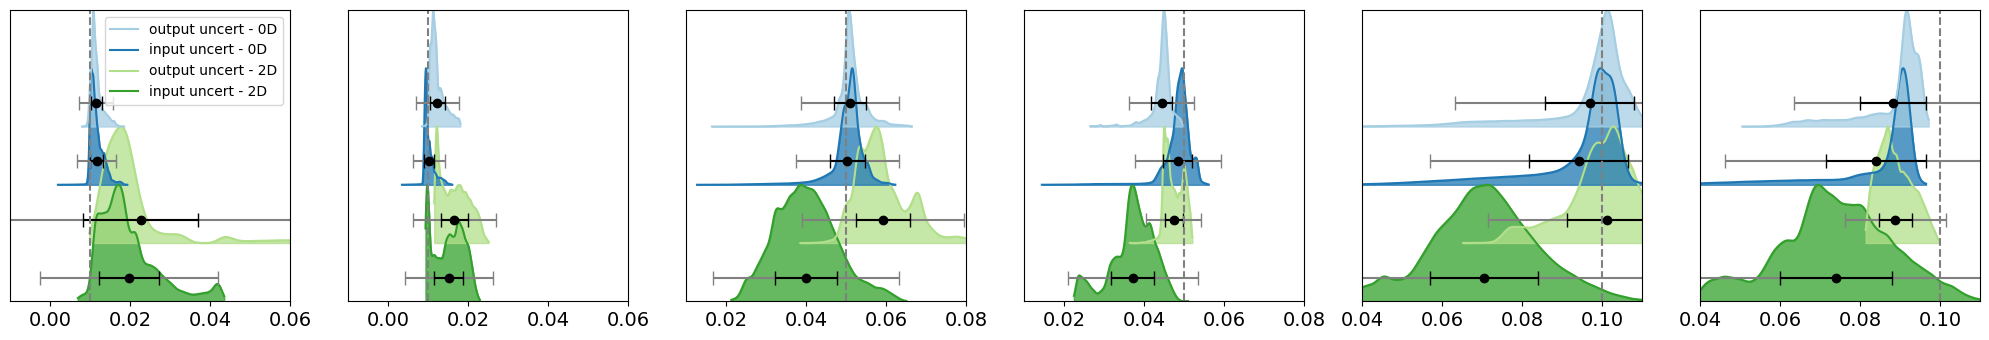

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy.stats import gaussian_kde

# suppress seaborn/pandas specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Example setup, use your actual data/model outputs
noise_list = ["low", "medium", "high"]
model_type = ["DE", "DER"]
inject_type_list = ["predictive", "feature"]
data_dim_list = ["0D", "2D"]

# Set up figure and axes
fig, axes = plt.subplots(1, len(model_type) * len(noise_list), figsize=(20, 3.5))
axes = axes.flatten()
index = 0

sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
palette = sns.color_palette("Paired", n_colors=len(data_dim_list) * len(inject_type_list))

# Define x-axis limits for each noise level
x_limits = {
    "low": (0, 0.05),
    "medium": (0, 0.1),
    "high": (0, 0.12)
}

for n, noise in enumerate(noise_list):
    for m, model in enumerate(model_type):
        ax = axes[index]
        
        y_offset = 0  # Initialize a consistent y_offset
        kde_max = 0  # Track the maximum y-value across all KDE plots
        
        # Collect KDE data to plot
        kde_data = []
        for j, dim in enumerate(data_dim_list):
            for i, inject_type in enumerate(inject_type_list):
                # Generate or load aleatoric uncertainty data (replace with your own logic)
                u_al_data = mega_dict[noise][model][dim][inject_type]
                
                
                # Stack the DEs
                if model == "DE":
                    combined_array = np.concatenate(u_al_data)
                elif model == "DER":
                    combined_array = u_al_data
                
                # Store KDE data
                kde_data.append((combined_array, palette[j*len(inject_type_list)+i], f"{new_title_lookup[inject_type]} - {dim}"))
        
        # Plot KDEs in reverse order
        for combined_array, color, label in reversed(kde_data):
            '''
            kde = sns.kdeplot(combined_array, fill=True, bw_adjust=0.5, alpha=0.75, ax=ax,
                              clip_on=False, color=color, label=label)

            # Retrieve the KDE data
            x = kde.lines[0].get_data()[0]
            y = kde.lines[0].get_data()[1]
            
            # Normalize the KDE data
            max_height = 0.5  # Desired maximum height
            y_normalized = (y / y.max()) * max_height
            
            # Clear the previous KDE plot
            ax.clear()
            
            # Plot the normalized KDE
            ax.fill_between(x, y_normalized, color='blue', alpha=0.75)
            ax.plot(x, y_normalized, color='blue', label='Normalized KDE')
            '''
            # Compute KDE
            kde = gaussian_kde(combined_array, bw_method=0.1)  # Adjust bw_method as needed
            
            # Define range of x values
            x = np.linspace(min(combined_array), max(combined_array), 1000)
            
            # Evaluate KDE over x values
            y = kde(x)
            
            # Normalize the KDE data
            max_height = 0.5  # Desired maximum height
            y_normalized = (y / y.max()) * max_height
            
            # Plot the normalized KDE
            ax.fill_between(x, y_offset, y_normalized + y_offset, color=color, alpha=0.75)
            ax.plot(x, y_normalized + y_offset, color=color, label=label)
            
            '''
            # Find the maximum y-value and adjust offsets
            if kde.collections:
                paths = kde.collections[-1].get_paths()
                for path in paths:
                    vertices = path.vertices
                    vertices[:, 1] += y_offset  # Offset the y-values of the vertices
                    kde_max = vertices[:, 1].max() / 1.5
            '''
            ax.scatter(
                np.mean(combined_array), y_offset + 0.1,
                color='black', edgecolor='black', zorder=100)
            
            ax.errorbar(
                np.mean(combined_array), y_offset + 0.1,
                xerr = 3*np.std(combined_array),
                color='grey', capsize=5)
            ax.errorbar(
                np.mean(combined_array), y_offset + 0.1,
                xerr = np.std(combined_array),
                color='black', capsize=5)
            y_offset += 0.25

        # Set title and limits
        #ax.set_title(f'{model} - {noise} noise')
        ax.set_yticks([])  # Hide y-ticks
        ax.set_ylim(0, y_offset+0.25)  # Adjust y-limits based on the max y_offset
        
        # Set x-axis limits after plotting
        ax.set_xlim(x_limits[noise])

        # Add vertical line indicating sigma_y for reference
        if noise == "low":
            ax.axvline(x=0.01, color='grey', ls='--')
        elif noise == "medium":
            ax.axvline(x=0.05, color='grey', ls='--')
        elif noise == "high":
            ax.axvline(x=0.10, color='grey', ls='--')
        
        # Only add the legend on the first subplot
        if index == 0:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[::-1], labels[::-1], loc='upper right')  # Reverse the order of the legend
        else:
            ax.legend().remove()  # Remove the legend from all other subplots
        ax.set_yticklabels([])
        index += 1

axes[0].set_xlim([0, 0.06])
axes[1].set_xlim([0, 0.03])
axes[2].set_xlim([0.01, 0.09])
axes[3].set_xlim([0.01, 0.07])
axes[4].set_xlim([0.01, 0.13])
axes[5].set_xlim([0.01, 0.13])

axes[0].set_xlim([-0.01, 0.06])
axes[1].set_xlim([-0.01, 0.06])
axes[2].set_xlim([0.01, 0.08])
axes[3].set_xlim([0.01, 0.08])
axes[4].set_xlim([0.04, 0.11])
axes[5].set_xlim([0.04, 0.11])

axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=14)
axes[3].tick_params(axis='both', which='major', labelsize=14)
axes[4].tick_params(axis='both', which='major', labelsize=14)
axes[5].tick_params(axis='both', which='major', labelsize=14)

#axes[0].set_xlabel(r'$\sigma_{al}$')
plt.subplots_adjust(wspace=0)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig(f'../../../Desktop/sigma_in_sigma_out_ridgeplot_ensemble_{n_models}_uniform.png', dpi=1000)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

# suppress seaborn/pandas specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Example setup, use your actual data/model outputs
noise_list = ["low", "medium", "high"]
model_type = ["DE", "DER"]
inject_type_list = ["predictive", "feature"]
data_dim_list = ["0D", "2D"]

# Set up figure and axes
fig, axes = plt.subplots(1, len(model_type) * len(noise_list), figsize=(20, 3.5))
axes = axes.flatten()
index = 0

sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
palette = sns.color_palette("Paired", n_colors=len(data_dim_list) * len(inject_type_list))

# Define x-axis limits for each noise level
x_limits = {
    "low": (0, 0.05),
    "medium": (0, 0.1),
    "high": (0, 0.12)
}

for n, noise in enumerate(noise_list):
    for m, model in enumerate(model_type):
        ax = axes[index]
        
        y_offset = 0  # Initialize a consistent y_offset
        kde_max = 0  # Track the maximum y-value across all KDE plots
        
        # Collect KDE data to plot
        kde_data = []
        for j, dim in enumerate(data_dim_list):
            for i, inject_type in enumerate(inject_type_list):
                # Generate or load aleatoric uncertainty data (replace with your own logic)
                u_al_data = mega_dict[noise][model][dim][inject_type]
                
                
                # Stack the DEs
                if model == "DE":
                    combined_array = np.concatenate(u_al_data)
                elif model == "DER":
                    combined_array = u_al_data
                
                # Store KDE data
                kde_data.append((combined_array, palette[j*len(inject_type_list)+i], f"{inject_type} - {dim}"))
        
        # Plot KDEs in reverse order
        for combined_array, color, label in reversed(kde_data):
            kde = sns.kdeplot(combined_array, fill=True, bw_adjust=0.5, alpha=0.75, ax=ax,
                              clip_on=True, color=color, label=label, common_norm=1)
            
            # Find the maximum y-value and adjust offsets
            if kde.collections:
                paths = kde.collections[-1].get_paths()
                for path in paths:
                    vertices = path.vertices
                    vertices[:, 1] += y_offset  # Offset the y-values of the vertices
                    kde_max = vertices[:, 1].max() / 1.5
                    ax.scatter(
                        np.mean(combined_array), vertices[:, 1].mean(),
                        color=color, edgecolor='white', zorder=100)
                    
                    ax.errorbar(
                        np.mean(combined_array), vertices[:, 1].mean(),
                        xerr = 3*np.std(combined_array),
                        color='grey', capsize=5)
                    ax.errorbar(
                        np.mean(combined_array), vertices[:, 1].mean(),
                        xerr = np.std(combined_array),
                        color='black', capsize=5)
                y_offset += kde_max

        # Set title and limits
        ax.set_title(f'{model} - {noise} noise')
        ax.set_yticks([])  # Hide y-ticks
        ax.set_ylim(0, y_offset)  # Adjust y-limits based on the max y_offset
        
        # Set x-axis limits after plotting
        ax.set_xlim(x_limits[noise])

        # Add vertical line indicating sigma_y for reference
        if noise == "low":
            ax.axvline(x=0.01, color='grey', ls='--')
        elif noise == "medium":
            ax.axvline(x=0.05, color='grey', ls='--')
        elif noise == "high":
            ax.axvline(x=0.10, color='grey', ls='--')
        
        # Only add the legend on the first subplot
        if index == 0:
            ax.legend(loc='upper right')
        else:
            ax.legend().remove()  # Remove the legend from all other subplots
        ax.set_yticklabels([])
        index += 1

axes[0].set_xlim([0, 0.06])
axes[1].set_xlim([0, 0.03])
axes[2].set_xlim([0, 0.09])
axes[3].set_xlim([0, 0.09])
axes[4].set_xlim([0, 0.13])
axes[5].set_xlim([0, 0.13])

axes[0].set_xlabel(r'$\sigma_{al}$')
plt.subplots_adjust(wspace=-0.5, hspace=-0.5)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig(f'../../../Desktop/sigma_in_sigma_out_ridgeplot_ensemble_{n_models}_uniform.png', dpi=1000)